# K-Means algoritmus - Shluková analýza

K-Means (K-průměrů) je široce využívaný algoritmus nehierarchické shlukové analýzy. Hledá shluky dat v datovém prostoru s předpokladem, že tento prostor dat lze považovat za euklidovský a počet shluků je předem dán - *K*. Nejprve se v prostoru dat náhodně rozmístí *K* středů shluků - *centroidů*. Ty se poté iterativně posouvají tak, aby byly co nejpřesněji umístěny v těžištích shluků. K měření vzdáleností centroidů od datových bodů se nejčastěji využívá Eklidovské vzdálenosti.

Konvergence algoritmu je zaručena a poměrně rychlá. Není však zaručeno, že výsledkem bude globální optimum ve smyslu nejmenšího součtu čtverců vzdáleností od centroidů. Navíc pro různé volby počátečních centroidů mohou vzniknout různá řešení. 

Jak algoritmus K-Means postupuje je vizualizováno na následujícícm videu.

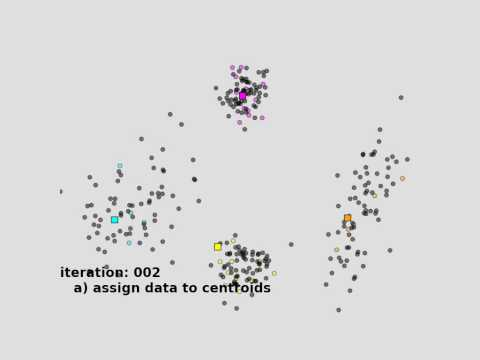

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('5I3Ei69I40s')

## Příklad - kvantizace barev v obraze - redukce barevné palety

V následujícícm příkladu využijeme algoritmus K-Means ke kvantování barev v obraze. Výsledkem kvantování bude paleta šestnácti barev, které nejlépe reprezentují barvy v původním obraze a tuto paletu poté využijeme k transformaci původníhu obrazu do šestnáctibarevné verze.

Nejprve načteme potřebné knihovny

- numpy: vědecká knihovna pro práci s daty
- matplotlib: knihovna pro vykreslování grafů
- sklearn: vědecká knihovna pro strojové učení
 * cluster: knihovna pro shlukovou analýzu
- cv2: knohovna pro strojové vidění - využijeme k načtení a předzpracování obrazu
- urlib.request - knihovna pro práci s Internetovými zdroji


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from urllib.request import urlopen

Nejprve načteme libovolný obrázek z Internetu pomocí funkce `urlopen()`, získaná data přečteme funkcí `read()`, převedeme na bajtové pole a dále převedeme na `numpy` pole.

Poté toto pole dekódujeme ze zdrojových dat (např. jpeg) na obrázek ve formátu bitové mapy pomocí fuknce `cv2.imdecode()`.

In [3]:
url = 'https://www.sverige.cz/wp-content/uploads/2016/12/sverige-svedsko-sundsvall-zapad-slunce-005.jpg'
resp = urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

Funkcí `imshow()` z knihovny `matplotlib` si můžeme obrázek zobrazit:

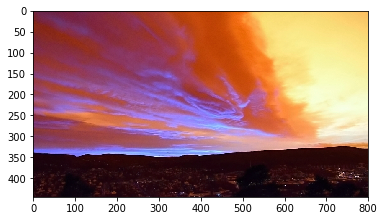

In [4]:
plt.imshow(image);

Pro algoritmus K-Means potřebujeme trojrozměrné pole obrázku (2D obrázek + barevný kanál v RGB) transformovat na vektor datových bodů (datový bod = barevný pixel). K tomu lze použít metodu (funkci) `numpy` pole `reshape()`, jejímž argumentem je tvar nového pole kde -1 reprezentuje dimenzi, jejíž rozměr má být dopočten dle velikosti původního pole. Vydělením hodnotou 255 (maximální hodnota barvy v RGB) vektor normalizujeme v intervalu $<0;1>$.

In [5]:
image_vector = image.reshape((-1, 3))/255

Rozměr matice původního obrázku je $445\times800\times3$ a nového pole pak $(445\cdot800)\times3$.

In [6]:
display(image.shape)
display(image_vector.shape)

(445, 800, 3)

(356000, 3)

Počet unikátních barev v původním obrázku můžeme zjistit pomocí `numpy` funkce `unique`, která zachová ze zdrojového pole jen unikátní vzorky. Definicíc parametru `axis` můžeme určit, pro kterou osu v poli se má operace provést, `axis=0` znamená po řádcích. V původním obrázku je tedy 80224 unikátních barev.

In [7]:
np.unique(image_vector, axis=0).shape

(80224, 3)

Nyní nastavíme parametry pro algoritmus K-Means.

- `n_colors` definuje počet hledaných shluků, tedy parametr $K$, ve výsledku počet barev v redukované paletě (kvanta).
- `n_samples` definuje kolik vzorků z 356000 pixelů chceme použít pro K-Means algoritmus (použít všechny by bylo velmi výpočetně náročné a zbytečné)

In [8]:
n_colors = 16
n_samples = 1000

Vytvoříme tedy nový vektor `image_vector_sample`, do kterého vyberem náhodně 1000 pixelů z původního obrazu. K tomu využijeme funkci `np.random.shuffle()`, které předáme počet vzorků  v původním obrazu, ta vrátí vektor, ve kterém budou náhodně rozházená čísla od 0 do 359999. Tento vektor pak použijeme k indexaci ve vektoru obsahujícícm pixely původního obrazu, čímž vytvoříme další vektor obsahujícíc náhodně rozházené pixely původního obrazu. Z něho pak vyberem prvních 1000 pixelů. 

In [12]:
image_vector_sample = image_vector[np.random.shuffle(np.arange(image_vector.shape[0]))][:n_samples]

Vytvoříme instance objektu `KMeans` s parametrem `n_clusters=n_colors`, který určuje počet hledaných centroidů a parametrem `n_init=10`, který určuje kolikrát se provede počáteční rozhození centroidů v prostoru dat. Instanci takto vytvořeného objektu uložíme do proměnné `estimator`.

In [13]:
estimator = KMeans(n_clusters=n_colors, n_init=10)

Zavoláním metody (funkce) `fit()` nad instancí objektu `estimator` spustíme itereativní učení algoritmu K-Means. Parametrem funkce je vektor vstupních dat, u něhož funkcí `squeeze()` odstraníme dimenze s velikostí 1.

In [16]:
estimator.fit(image_vector_sample.squeeze())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Polohy centroidů v barevném prostoru RGB jsou nyní dostupné v atributu (proměnné) instance objektu `estimator` s názvem `cluster_centers_`. Můžeme si je vykreslit opět pomocí funkce `imshow()`, ale je potřeba z nich vytvořit 3D pole "barevného obrázku". To provedeme funkcí `reshape()`, kterou změníme tvar 2D vektoru centroidů na pole o rozměrech $1\times16\times3$ (pro n_colors=16), tedy obrázek s jedním řádkem a 16 pixely v RGB.

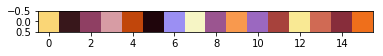

In [18]:
plt.imshow(estimator.cluster_centers_.reshape(1,n_colors,3));

Nyní můžeme naučené instanci objektu `estimator` předložit datový bod v RGB pomocí metody `predict()` a získáme pořadové číslo shluku , ke kterému datový bod patří. Polohu shluku pak získáme z vektoru `cluster_centers_`, kde pořadové číslo je index do tohoto vektoru. Funkce `predict()` předpokládá jako vstupní data vektor datových bodů.

In [19]:
display(image_vector[0])
prediction = estimator.predict([image_vector[0]])
display(prediction)
display(estimator.cluster_centers_[prediction])

array([0.41960784, 0.14901961, 0.25490196])

array([14], dtype=int32)

array([[0.53072948, 0.17955004, 0.23386416]])

Vzhledem k tomu, že vstupní data se do metody `predict()` vkládají ve formátu vektoru datových bodů, můžeme jednoduše provézt přiřazení pořadového číslo shluku ke všem pixelům původního obrázku. Je zřejmé, že oproti učení je vybavení u algoritmu K-Means velmi rychlé.

In [20]:
image_16_vector_classes = estimator.predict(image_vector)

Převod z pořadových čísel shluků pro všechny pixely na hodnoty RGB centroidů je stejný jako pro jeden datový bod.

In [21]:
image_16_vector = estimator.cluster_centers_[image_16_vector_classes]

Obrázek z vektoru datových bodů vytvoříme opětovnou změnou tvaru pole zpět na tvar pole z původním obrázkem pomocí funkce `reshape()`.

In [22]:
image_16 = image_16_vector.reshape(image.shape)

Nyní si pod sebe můžeme zobrazit pomocí funkce `imshow()` původní obrázek a obrázek s kvantováním redukovanou barevnou paletou.
Funkce `Figure()` inicializuje nové plátno pro vykreslování, jinak by opětovným voláním funkce `imshow()` byl první vykreslený obrázek překreslen.

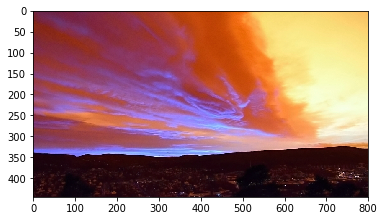

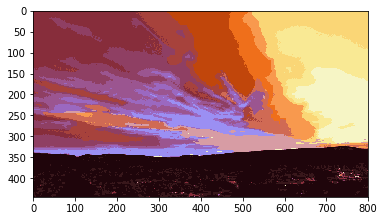

In [23]:
plt.imshow(image)
plt.figure()
plt.imshow(image_16);